In [19]:
import pandas as pd
import contractions
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from urlextract import URLExtract


#Analysis
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.corpora import Dictionary
from gensim.models import LdaModel

In [20]:
def load_data(filename):
    """
    Load data from a CSV file and return the 'text' column.

    Parameters:
    filename (str): The path to the CSV file.

    Returns:
    pandas.Series: The 'text' column of the loaded DataFrame.
    """
    df = pd.read_csv(filename)
    texts = df['text']
    return df, texts

filename = "/Users/sameerladha/Documents/School/Masters of Science - Data Science and Analytics/MRP/Datasets/csv/ogftfinal_.csv"
df, texts = load_data(filename)

### Preprocessing

In [21]:
def generate_generic_username(index):
    """
    Generates a generic username to ensure users remain private when going though the data.

    Parameters:
    index (int): The index used to generate the username.

    Returns:
    str: The generated generic username.
    """
    return f"User{index+1}"

unique_authors = df['author'].unique()
author_mapping = {author: f"User{i+1}" for i, author in enumerate(unique_authors)}
df['author'] = df['author'].map(author_mapping)

In [22]:
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))
extractor = URLExtract()

lemmatizer = WordNetLemmatizer()

def is_url(token):
    """
    Check if a given token represents a URL.

    Parameters:
    token (spacy.Token): The token to be checked.

    Returns:
    bool: True if the token represents a URL, False otherwise.
    """
    return token.like_url

# Function to preprocess text
def process_text(text):
    """
    Preprocesses the given text by converting it to lowercase, expanding contractions,
    tokenizing it using spaCy, removing stop words, URLs, and short tokens, and returning
    the processed tokens.
    
    Args:
        text (str): The text to be processed.
    
    Returns:
        list: The processed tokens.
    """
    if pd.isnull(text):
        # Return a placeholder token if the text is missing
        return ["text_missing"]
    
    text = text.lower()
    text = contractions.fix(text)
    
    # Process text with spaCy
    doc = nlp(text)
    
    # Tokenization, stop word removal, URL removal, and short token filtering
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and not is_url(token)]
    tokens = [tokens for tokens in tokens if len(tokens) > 4]
    
    return tokens

In [23]:
def preprocess_texts(texts):
    """
    Preprocesses a list of texts by applying the 'process_text' function to each text and removing texts that are missing.

    Args:
        texts (list): A list of texts to be preprocessed.

    Returns:
        list: The preprocessed texts, with missing texts removed.
    """
    processed_texts = [process_text(text) for text in texts]
    #Removes any text that is deemed missing from the dataset
    processed_texts = [text for text in processed_texts if text != ["text_missing"]]
    return processed_texts

# Preprocess the texts
processed_texts = preprocess_texts(texts)

### Data Preparation

In [24]:
# Create bigrams and trigrams
# The Phrases class from gensim is used to detect common phrases (bigrams and trigrams) in the text.
# - `processed_texts`: List of tokenized texts.
# - `min_count=3`: Ignores all words and phrases with a total frequency lower than this.
# - `threshold=100`: Represents a threshold for forming the phrases (higher means fewer phrases).
bigram = Phrases(processed_texts, min_count=3, threshold=100)
trigram = Phrases(bigram[processed_texts], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
# The Phraser class is a more efficient way to apply the phrases model to a list of texts.
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)


def make_bigrams(texts):
    """
    Applies bigram model to a list of texts.

    Parameters:
    texts (list): A list of texts.

    Returns:
    list: A list of bigrams for each text in the input list.
    """
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    """
    Applies trigram model to a list of texts.

    Parameters:
    texts (list): A list of texts.

    Returns:
    list: A list of trigrams for each text in the input list.
    """
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Apply bigrams and trigrams
# The functions are called to transform the processed texts into bigrams and trigrams.
texts_bigrams = make_bigrams(processed_texts)
texts_trigrams = make_trigrams(processed_texts)

In [25]:
# Create Dictionary
# The Dictionary class from gensim is used to create a mapping from word IDs to words.
# - `texts_trigrams`: List of tokenized texts with trigrams.
id2word = Dictionary(texts_trigrams)

# Filter extremes to remove very rare and very common words
# The filter_extremes method is used to filter out tokens that are too rare or too common.
# - `no_below=10`: Keep tokens that appear in at least 10 documents.
# - `no_above=0.2`: Keep tokens that appear in no more than 20% of the documents.
id2word.filter_extremes(no_below=10, no_above=0.2)

# Create Corpus
# The corpus is created by converting each document to a bag-of-words format.
# - `id2word.doc2bow(text)`: Converts a document into a list of (token_id, token_count) tuples.
# - `texts_trigrams`: List of tokenized texts with trigrams.
texts_corpus = [id2word.doc2bow(text) for text in texts_trigrams]

In [26]:
# Convert tokenized documents back to strings
documents = [' '.join(text) for text in processed_texts]

# The SentimentIntensityAnalyzer from the VADER sentiment analysis tool is initialized.
sid = SentimentIntensityAnalyzer()

# Function to get sentiment score
def get_sentiment_score(document):
    """
    Calculate the sentiment score of a given document.

    Parameters:
    document (str): The text document for which sentiment score needs to be calculated.

    Returns:
    float: The sentiment score of the document. The score ranges from -1 to 1, where -1 indicates
        extremely negative sentiment, 0 indicates neutral sentiment, and 1 indicates extremely
        positive sentiment.
    """
    return sid.polarity_scores(document)['compound']

# Apply sentiment analysis to each document
# The sentiment score is calculated for each document in the list.
document_sentiments = [get_sentiment_score(doc) for doc in documents]

# The average sentiment score is calculated from the list of sentiment scores.
average_sentiment_score = sum(document_sentiments) / len(document_sentiments)

print(f"Average Sentiment Score for the Subreddit: {average_sentiment_score}")

Average Sentiment Score for the Subreddit: 0.005999986210700448


### Building the Model

In [27]:
# Build LDA model
# The LdaModel class from gensim is used to create a Latent Dirichlet Allocation (LDA) model.
# - `corpus`: The corpus in bag-of-words format.
# - `id2word`: The dictionary mapping word IDs to words.
# - `num_topics=5`: The number of topics to be extracted from the corpus.
# - `random_state=100`: The random seed for reproducibility.
# - `update_every=1`: Number of documents to be iterated through for each update.
# - `chunksize=2500`: Number of documents to be used in each training chunk.
# - `passes=40`: Number of passes through the entire corpus during training.
# - `iterations=100`: Maximum number of iterations through the corpus when inferring the topic distribution.
# - `alpha='auto'`: The prior on the per-document topic distribution. By setting it to 'auto', the model will automatically learn an asymmetric prior from the data.
# - `per_word_topics=True`: If True, the model also computes a list of topics, sorted in descending order of most likely topics for each word.
lda_model = LdaModel(corpus=texts_corpus,
                     id2word=id2word,
                     num_topics=5, 
                     random_state=100,
                     update_every=1,
                     chunksize=2500,
                     passes=40,
                     iterations=100,
                     alpha='auto',
                     per_word_topics=True)

In [28]:
# Function to calculate coherence score
def compute_coherence_score(lda_model, texts, dictionary, coherence='c_v'):
    """
    Compute the coherence score for a given LDA model.

    Parameters:
    - lda_model (gensim.models.LdaModel): The trained LDA model.
    - texts (list): List of tokenized texts used for training the LDA model.
    - dictionary (gensim.corpora.Dictionary): The dictionary used for training the LDA model.
    - coherence (str, optional): The type of coherence score to compute. Default is 'c_v'.

    Returns:
    - coherence_score (float): The coherence score of the LDA model.
    """
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence=coherence)
    coherence_score = coherence_model.get_coherence()
    return coherence_score

# Function to calculate perplexity
def compute_perplexity(lda_model, corpus):
    """
    Compute the perplexity of an LDA model on a given corpus.

    Parameters:
    lda_model (gensim.models.LdaModel): The trained LDA model.
    corpus (list of list of (int, int)): The corpus in bag-of-words format.

    Returns:
    float: The perplexity score of the LDA model on the given corpus.
    """
    perplexity = lda_model.log_perplexity(corpus)
    return perplexity

def display_formatted_topics(lda_model, num_words):
    """
    Display the formatted topics generated by the LDA model.

    Parameters:
    - lda_model (LdaModel): The trained LDA model.
    - num_words (int): The number of words to display per topic.

    Returns:
    None
    """
    topics = lda_model.print_topics(num_words=num_words)
    for topic in topics:
        topic_id, topic_words = topic
        print(f"Topic {topic_id}:")
        words = topic_words.split(" + ")
        for word in words:
            weight, term = word.split("*")
            print(f"  {term.strip()} ({float(weight):.3f})")
        print("\n")

coherence_score = compute_coherence_score(lda_model, texts_trigrams, id2word)
print(f"Coherence Score: {coherence_score:.3f}")

perplexity = compute_perplexity(lda_model, texts_corpus)
print(f"Perplexity: {perplexity:.3f}")

print("LDA Topics:")
display_formatted_topics(lda_model, num_words=20)

Coherence Score: 0.536
Perplexity: -6.683
LDA Topics:
Topic 0:
  "housing" (0.057)
  "immigration" (0.034)
  "problem" (0.023)
  "build" (0.021)
  "people" (0.020)
  "blame" (0.015)
  "immigrant" (0.015)
  "house" (0.014)
  "government" (0.014)
  "price" (0.014)
  "market" (0.013)
  "demand" (0.012)
  "issue" (0.012)
  "crisis" (0.012)
  "supply" (0.011)
  "increase" (0.011)
  "solution" (0.009)
  "policy" (0.009)
  "remove" (0.008)
  "thing" (0.008)


Topic 1:
  "people" (0.069)
  "think" (0.019)
  "thing" (0.015)
  "student" (0.011)
  "money" (0.010)
  "actually" (0.010)
  "country" (0.009)
  "happen" (0.009)
  "family" (0.007)
  "position" (0.007)
  "world" (0.006)
  "school" (0.006)
  "racist" (0.006)
  "canada" (0.006)
  "employee" (0.006)
  "system" (0.006)
  "reason" (0.006)
  "maybe" (0.005)
  "start" (0.005)
  "thank" (0.005)


Topic 2:
  "canada" (0.034)
  "immigrant" (0.030)
  "canadian" (0.027)
  "worker" (0.023)
  "people" (0.021)
  "immigration" (0.020)
  "country" (0.017

### Tuning the Model to determine the optimal number of topics

In [29]:
# Function to calculate coherence values for a range of topic numbers
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1, coherence='c_v'):
    """
    Compute coherence values for a range of LDA models with different numbers of topics.

    Parameters:
    - dictionary (gensim.corpora.Dictionary): The dictionary mapping of words to their integer ids.
    - corpus (list of list of tuples): The document-term matrix.
    - texts (list of list of str): The preprocessed texts.
    - limit (int): The maximum number of topics to consider.
    - start (int, optional): The starting number of topics. Defaults to 2.
    - step (int, optional): The step size for incrementing the number of topics. Defaults to 1.
    - coherence (str, optional): The coherence metric to use. Defaults to 'c_v'.

    Returns:
    - model_list (list of gensim.models.ldamodel.LdaModel): The list of trained LDA models.
    - coherence_values (list of float): The coherence values for each LDA model.
    """
    coherence_values = []
    model_list = []
    total_models = (limit - start) // step + 1
    current_model_count = 0
    
    for num_topics in range(start, limit, step):
        # Build LDA model
            # The LdaModel class from gensim is used to create a Latent Dirichlet Allocation (LDA) model.
            # - `corpus`: The corpus in bag-of-words format.
            # - `id2word`: The dictionary mapping word IDs to words.
            # - `num_topics=5`: The number of topics to be extracted from the corpus.
            # - `random_state=100`: The random seed for reproducibility.
            # - `update_every=1`: Number of documents to be iterated through for each update.
            # - `chunksize=2500`: Number of documents to be used in each training chunk.
            # - `passes=40`: Number of passes through the entire corpus during training.
            # - `iterations=100`: Maximum number of iterations through the corpus when inferring the topic distribution.
            # - `alpha='auto'`: The prior on the per-document topic distribution. By setting it to 'auto', the model will automatically learn an asymmetric prior from the data.
            # - `per_word_topics=True`: If True, the model also computes a list of topics, sorted in descending order of most likely topics for each word.
        
        lda_model = gensim.models.ldamodel.LdaModel(
            corpus=corpus, 
            id2word=dictionary, 
            num_topics=num_topics,
            random_state=100, 
            update_every=1, 
            chunksize=2500, 
            iterations=100, 
            passes=40, 
            alpha='auto', 
            per_word_topics=False
        )
        model_list.append(lda_model)
        
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence=coherence)
        coherence_values.append(coherence_model.get_coherence())
        
        current_model_count += 1
        print(f"Built {current_model_count} of {total_models} models")
    
    return model_list, coherence_values

def visualize_coherence_values(limit, start, step, coherence_values):
    """
    Visualizes the coherence scores for different number of topics.

    Parameters:
    limit (int): The upper limit of the range of number of topics.
    start (int): The starting point of the range of number of topics.
    step (int): The step size between each number of topics.
    coherence_values (list): A list of coherence scores for different number of topics.

    Returns:
    None
    """
    x = range(start, limit, step)
    plt.figure(figsize=(10, 8))
    plt.plot(x, coherence_values, marker='o', linestyle='-', color='b')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Scores for Different Number of Topics")

    # Annotate each point with its coherence score
    for i, (num_topics, coherence) in enumerate(zip(x, coherence_values)):
        plt.annotate(f"{coherence:.3f}", (num_topics, coherence), textcoords="offset points", xytext=(0, 10), ha='center')
    plt.show()


Built 1 of 4 models
Built 2 of 4 models
Built 3 of 4 models


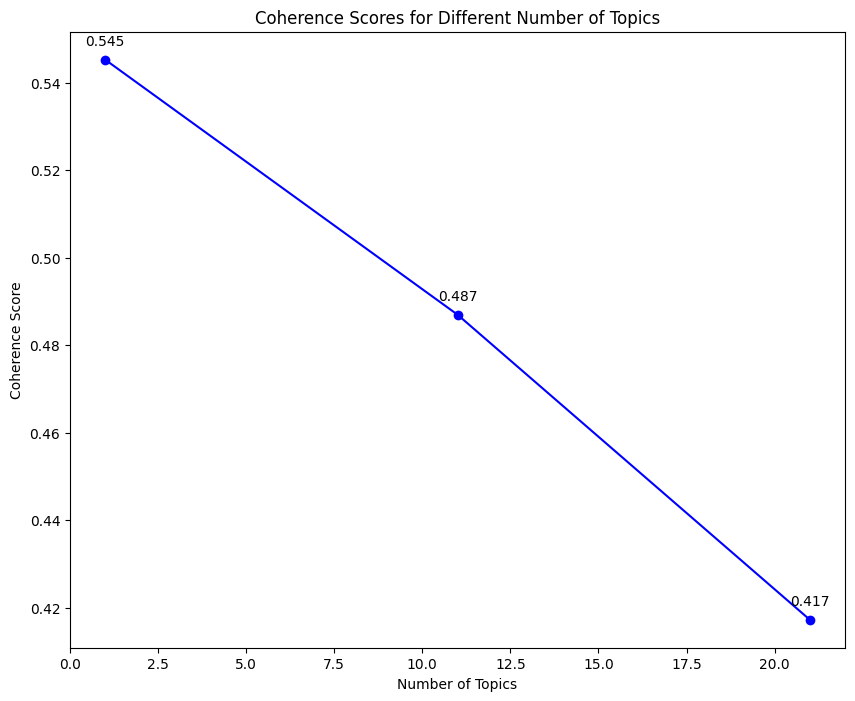

In [30]:
#Testing to determine the optimal number of topics using arbritrary values
limit=31; start=1; step=10


#Implement the functions
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=texts_corpus, texts=texts_trigrams, start=start, limit=limit, step=step)
visualize_coherence_values(limit, start, step, coherence_values)

Built 1 of 10 models
Built 2 of 10 models
Built 3 of 10 models
Built 4 of 10 models
Built 5 of 10 models
Built 6 of 10 models
Built 7 of 10 models
Built 8 of 10 models
Built 9 of 10 models


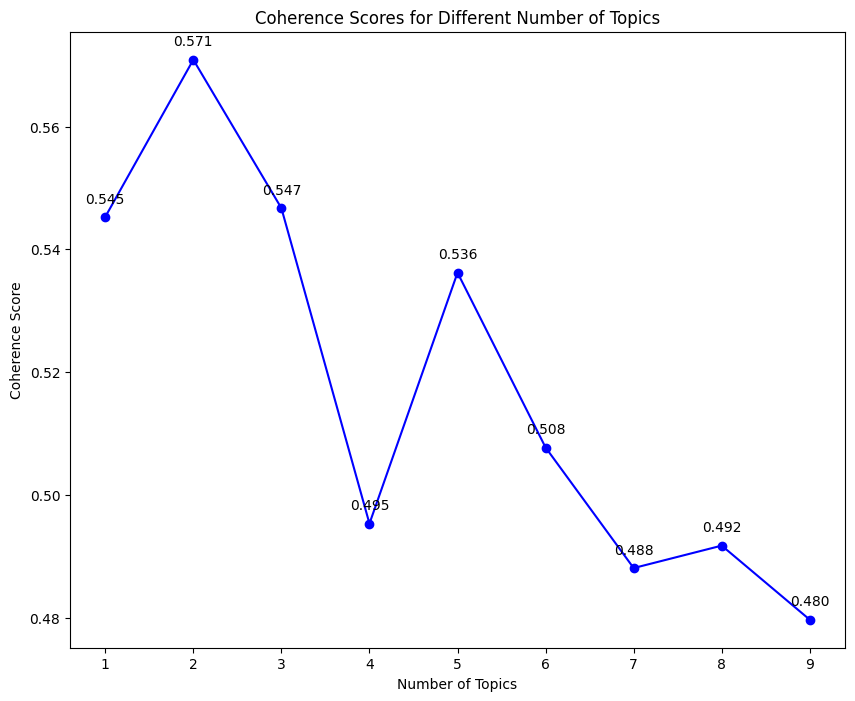

In [31]:
#Testing to determine the optimal number of topics within a smaller window based on the starting values
#The number of topics is determined by the coherence score, which is calculated for each model and is determined visually from the graph above.
limit=10; start=1; step=1
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=texts_corpus, texts=texts_trigrams, start=start, limit=limit, step=step)
visualize_coherence_values(limit, start, step, coherence_values)

### Final Model

In [36]:
#Optimal Number of Topics based on the graph above
x = 2

#Final runthrough with the optimal number of topics
# Build LDA model
# The LdaModel class from gensim is used to create a Latent Dirichlet Allocation (LDA) model.
# - `corpus`: The corpus in bag-of-words format.
# - `id2word`: The dictionary mapping word IDs to words.
# - `num_topics=5`: The number of topics to be extracted from the corpus.
# - `random_state=100`: The random seed for reproducibility.
# - `update_every=1`: Number of documents to be iterated through for each update.
# - `chunksize=2500`: Number of documents to be used in each training chunk.
# - `passes=40`: Number of passes through the entire corpus during training.
# - `iterations=100`: Maximum number of iterations through the corpus when inferring the topic distribution.
# - `alpha='auto'`: The prior on the per-document topic distribution. By setting it to 'auto', the model will automatically learn an asymmetric prior from the data.
# - `per_word_topics=True`: If True, the model also computes a list of topics, sorted in descending order of most likely topics for each word.
lda_model = LdaModel(corpus=texts_corpus,
                     id2word=id2word,
                     num_topics=x, 
                     random_state=100,
                     update_every=1,
                     chunksize=2500,
                     passes=40,
                     iterations=100,
                     alpha='auto',
                     per_word_topics=True)

In [37]:
coherence_score = compute_coherence_score(lda_model, texts_trigrams, id2word)
print(f"Coherence Score: {coherence_score:.3f}")

perplexity = compute_perplexity(lda_model, texts_corpus)
print(f"Perplexity: {perplexity:.3f}")

print("LDA Topics:")
display_formatted_topics(lda_model, num_words=25)

Coherence Score: 0.571
Perplexity: -6.618
LDA Topics:
Topic 0:
  "people" (0.030)
  "housing" (0.028)
  "immigration" (0.025)
  "immigrant" (0.019)
  "problem" (0.013)
  "canada" (0.011)
  "build" (0.010)
  "government" (0.009)
  "canadian" (0.009)
  "worker" (0.009)
  "increase" (0.008)
  "issue" (0.008)
  "house" (0.008)
  "blame" (0.008)
  "think" (0.008)
  "country" (0.007)
  "number" (0.007)
  "money" (0.007)
  "price" (0.007)
  "market" (0.006)
  "demand" (0.006)
  "bring" (0.006)
  "thing" (0.006)
  "crisis" (0.006)
  "policy" (0.006)


Topic 1:
  "people" (0.018)
  "conservative" (0.017)
  "canada" (0.017)
  "right" (0.016)
  "think" (0.013)
  "liberal" (0.013)
  "canadian" (0.012)
  "party" (0.011)
  "government" (0.010)
  "country" (0.009)
  "thing" (0.008)
  "support" (0.007)
  "trudeau" (0.007)
  "election" (0.006)
  "foreign" (0.005)
  "point" (0.005)
  "actually" (0.005)
  "believe" (0.005)
  "interference" (0.005)
  "report" (0.005)
  "public" (0.004)
  "happen" (0.004)


In [38]:
# Function to get topic names from user
def name_topics(lda_model):
    """
    Prompts the user to name each topic in the LDA model.

    Args:
        lda_model (LdaModel): The trained LDA model.

    Returns:
        dict: A dictionary mapping topic IDs to their corresponding names.
    """
    topic_names = {}
    for topic_id in range(lda_model.num_topics):
        # Get the top words for the topic
        top_words = [word for word, _ in lda_model.show_topic(topic_id, topn=15)]
        print(f"Topic {topic_id} Top Words: {', '.join(top_words)}")
        # Prompt user for topic name
        topic_name = input(f"Enter a name for Topic {topic_id}: ")
        topic_names[topic_id] = topic_name
    return topic_names

# Get topic names from user
topic_names = name_topics(lda_model)

# Print the topic names
for topic_id, topic_name in topic_names.items():
    print(f"Topic {topic_id}: {topic_name}")

Topic 0 Top Words: people, housing, immigration, immigrant, problem, canada, build, government, canadian, worker, increase, issue, house, blame, think
Topic 1 Top Words: people, conservative, canada, right, think, liberal, canadian, party, government, country, thing, support, trudeau, election, foreign
Topic 0: 0
Topic 1: 1


Topic 0 (0) Sentiment Score: -0.04397600000000001
Topic 1 (1) Sentiment Score: 0.032152


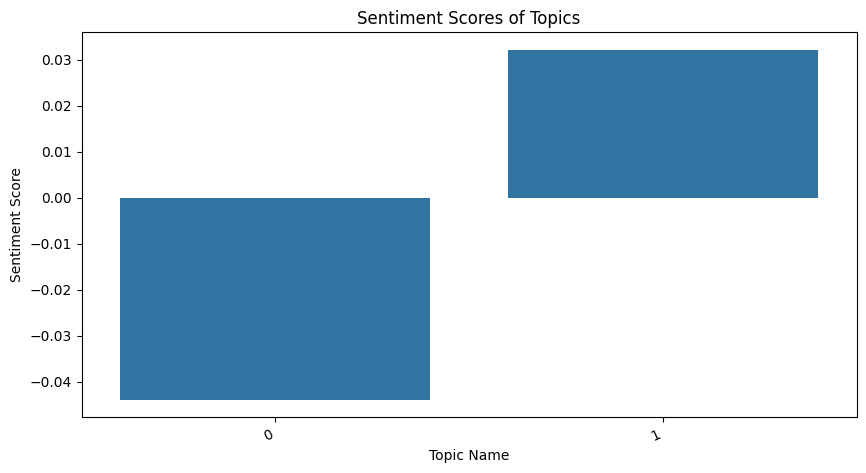

In [39]:
# The SentimentIntensityAnalyzer from the VADER sentiment analysis tool is initialized.
sid = SentimentIntensityAnalyzer()

# Function to get sentiment scores for words
def get_word_sentiments(words):
    """
    Calculate the average sentiment score for a list of words.

    Parameters:
    words (list): A list of words for which sentiment scores need to be calculated.

    Returns:
    float: The average sentiment score for the given list of words. If the list is empty, returns 0.
    """
    sentiments = [sid.polarity_scores(word)['compound'] for word in words]
    return sum(sentiments) / len(sentiments) if sentiments else 0

# Analyze sentiment for each topic
topic_sentiments = []
for topic_id in range(lda_model.num_topics):
    topic_words = [word for word, _ in lda_model.show_topic(topic_id, topn=25)]
    sentiment_score = get_word_sentiments(topic_words)
    topic_sentiments.append((topic_id, sentiment_score, topic_names[topic_id]))

# Print topic sentiments
for topic_id, sentiment_score, topic_name in topic_sentiments:
    print(f"Topic {topic_id} ({topic_name}) Sentiment Score: {sentiment_score}")

# Visualize sentiment scores
topic_ids, sentiment_scores, topic_names_list = zip(*topic_sentiments)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(topic_names_list), y=list(sentiment_scores))
plt.xlabel('Topic Name')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Scores of Topics')
plt.xticks(rotation=25, ha='right')
plt.show()